In [1]:
%pwd

'/home/zwx/segment-anything-flask/test'

## Import a demo image

In [2]:
import cv2
import matplotlib.pyplot as plt

In [3]:
path2img = "../assets/dog.jpg"
image = cv2.imread(path2img)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(image.shape)

(193, 261, 3)


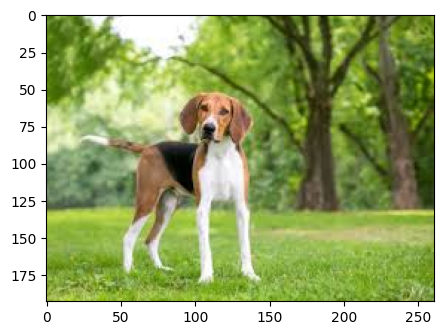

In [4]:
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('on')
plt.show()

## Embedding the image

image -[image encoder]-> image embedding

In [5]:
from segment_anything import sam_model_registry, SamPredictor
import onnxruntime
import numpy as np

In [6]:
path2ckpt = "../assets/sam_vit_b_01ec64.pth"
model_type = "vit_b"
device = "cuda"

In [7]:
sam = sam_model_registry[model_type](checkpoint=path2ckpt)
sam.to(device=device)
predictor = SamPredictor(sam)

In [8]:
predictor.set_image(image)
image_embedding = predictor.get_image_embedding().cpu().numpy()
print(image_embedding.shape)

(1, 256, 64, 64)


## Decode the embedding (ONNX)

In [9]:
'''
the point (x, y) that will be passed to mask decoder
+——————————+
|    | y   |
+----+     | height
|  x       |
+——————————+
    width
'''
input_point = np.array([[100, 100]])
input_label = np.array([1])

# Add a batch index, concatenate a padding point, and transform.
onnx_coord = np.concatenate([input_point, np.array([[0.0, 0.0]])], axis=0)[None, :, :]
onnx_label = np.concatenate([input_label, np.array([-1])], axis=0)[None, :].astype(np.float32)
onnx_coord = predictor.transform.apply_coords(onnx_coord, image.shape[:2]).astype(np.float32)

# Create an empty mask input and an indicator for no mask.
onnx_mask_input = np.zeros((1, 1, 256, 256), dtype=np.float32)
onnx_has_mask_input = np.zeros(1, dtype=np.float32)

# Package the inputs to run in the onnx model
ort_inputs = {
  "image_embeddings": image_embedding,
  "point_coords": onnx_coord,
  "point_labels": onnx_label,
  "mask_input": onnx_mask_input,
  "has_mask_input": onnx_has_mask_input,
  "orig_im_size": np.array(image.shape[:2], dtype=np.float32)
}

In [10]:
onnx_model_path = "../assets/sam_onnx_vit_b.onnx"
ort_session = onnxruntime.InferenceSession(onnx_model_path)

In [11]:
# Predict a mask and threshold it.
masks, _, low_res_logits = ort_session.run(None, ort_inputs)
masks = masks > predictor.model.mask_threshold

print(masks.shape, type(masks))

(1, 1, 193, 261) <class 'numpy.ndarray'>


## Display the result

In [17]:
def show_mask(mask, ax):
  color = np.array([30/255, 144/255, 255/255, 0.6])
  h, w = mask.shape[-2:]
  mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
  ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
  pos_points = coords[labels==1]
  neg_points = coords[labels==0]
  ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
  ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
  x0, y0 = box[0], box[1]
  w, h = box[2] - box[0], box[3] - box[1]
  ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))   

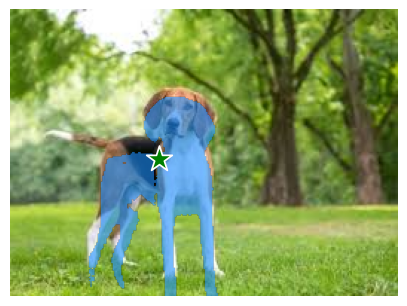

In [23]:
plt.figure(figsize=(5,5))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show()